# 图像增广
:label:`sec_image_augmentation`

 :numref:`sec_alexnet`提到过大型数据集是成功应用深度神经网络的先决条件。
图像增广在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模。
此外，应用图像增广的原因是，随机改变训练样本可以减少模型对某些属性的依赖，从而提高模型的泛化能力。
例如，我们可以以不同的方式裁剪图像，使感兴趣的对象出现在不同的位置，减少模型对于对象出现位置的依赖。
我们还可以调整亮度、颜色等因素来降低模型对颜色的敏感度。
可以说，图像增广技术对于AlexNet的成功是必不可少的。本节将讨论这项广泛应用于计算机视觉的技术。


In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## 常用的图像增广方法

在对常用图像增广方法的探索时，我们将使用下面这个尺寸为$400\times 500$的图像作为示例。


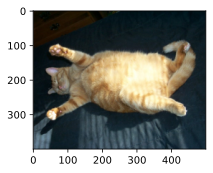

In [2]:
d2l.set_figsize()
img = d2l.Image.open('../img/cat1.jpg')
d2l.plt.imshow(img);

大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数`apply`。
此函数在输入图像`img`上多次运行图像增广方法`aug`并显示所有结果。


In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 翻转和裁剪

[**左右翻转图像**]通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。
接下来，我们使用`transforms`模块来创建`RandomFlipLeftRight`实例，这样就各有50%的几率使图像向左或向右翻转。


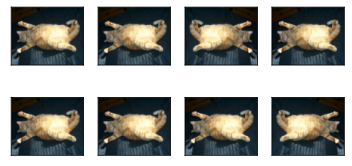

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

[**上下翻转图像**]不如左右图像翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。接下来，我们创建一个`RandomFlipTopBottom`实例，使图像各有50%的几率向上或向下翻转。


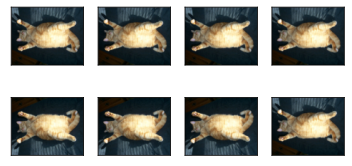

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

在我们使用的示例图像中，猫位于图像的中间，但并非所有图像都是这样。
在 :numref:`sec_pooling`中，我们解释了汇聚层可以降低卷积层对目标位置的敏感性。
另外，我们可以通过对图像进行随机裁剪，使物体以不同的比例出现在图像的不同位置。
这也可以降低模型对目标位置的敏感性。

下面的代码将[**随机裁剪**]一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。
然后，区域的宽度和高度都被缩放到200像素。
在本节中（除非另有说明），$a$和$b$之间的随机数指的是在区间$[a, b]$中通过均匀采样获得的连续值。


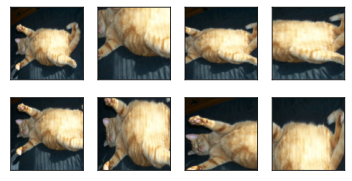

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 改变颜色

另一种增广方法是改变颜色。
我们可以改变图像颜色的四个方面：亮度、对比度、饱和度和色调。
在下面的示例中，我们[**随机更改图像的亮度**]，随机值为原始图像的50%（$1-0.5$）到150%（$1+0.5$）之间。


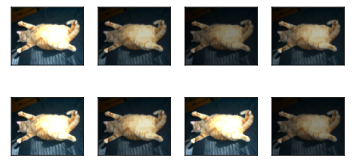

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

同样，我们可以[**随机更改图像的色调**]。


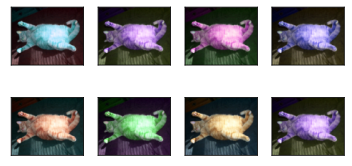

In [8]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

我们还可以创建一个`RandomColorJitter`实例，并设置如何同时[**随机更改图像的亮度（`brightness`）、对比度（`contrast`）、饱和度（`saturation`）和色调（`hue`）**]。


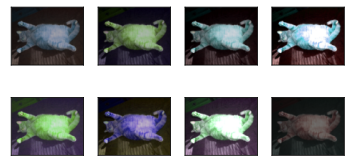

In [9]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

### [**结合多种图像增广方法**]

在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个`Compose`实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。


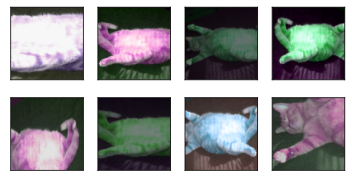

In [10]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

## [**使用图像增广进行训练**]

让我们使用图像增广来训练模型。
这里，我们使用CIFAR-10数据集，而不是我们之前使用的Fashion-MNIST数据集。
这是因为Fashion-MNIST数据集中对象的位置和大小已被规范化，而CIFAR-10数据集中对象的颜色和大小差异更明显。
CIFAR-10数据集中的前32个训练图像如下所示。


57.6%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Extracting ../data/cifar-10-python.tar.gz to ../data


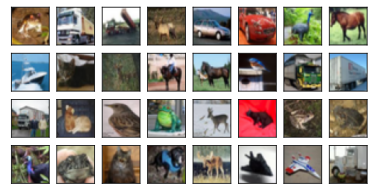

0.1%

0.1%

0.1%

0.1%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.3%

0.3%

0.3%

0.3%

0.3%

0.4%

0.4%

0.4%

0.4%

0.4%

0.5%

0.5%

0.5%

0.5%

0.5%

0.6%

0.6%

0.6%

0.6%

0.6%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.8%

0.8%

0.8%

0.8%

0.8%

0.9%

0.9%

0.9%

0.9%

0.9%

1.0%

1.0%

1.0%

1.0%

1.0%

1.1%

1.1%

1.1%

1.1%

1.1%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.3%

1.3%

1.3%

1.3%

1.3%

1.4%

1.4%

1.4%

1.4%

1.4%

1.5%

1.5%

1.5%

1.5%

1.5%

1.6%

1.6%

1.6%

1.6%

1.6%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.8%

1.8%

1.8%

1.8%

1.8%

1.9%

1.9%

1.9%

1.9%

1.9%

2.0%

2.0%

2.0%

2.0%

2.0%

2.1%

2.1%

2.1%

2.1%

2.1%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.3%

2.3%

2.3%

2.3%

2.3%

2.4%

2.4%

2.4%

2.4%

2.4%

2.5%

2.5%

2.5%

2.5%

2.5%

2.6%

2.6%

2.6%

2.6%

2.6%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.8%

2.8%

2.8%

2.8%

2.8%

2.9%

2.9%

2.9%

2.9%

2.9%

3.0%

3.0%

3.0%

3.0%

3.0%

3.1%

3.1%

3.1%

3.1%

3.1%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.3%

3.3%

3.3%

3.3%

3.3%

3.4%

3.4%

3.4%

3.4%

3.4%

3.5%

3.5%

3.5%

3.5%

3.5%

3.6%

3.6%

3.6%

3.6%

3.6%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.8%

3.8%

3.8%

3.8%

3.8%

3.9%

3.9%

3.9%

3.9%

3.9%

4.0%

4.0%

4.0%

4.0%

4.0%

4.1%

4.1%

4.1%

4.1%

4.1%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.3%

4.3%

4.3%

4.3%

4.3%

4.4%

4.4%

4.4%

4.4%

4.4%

4.5%

4.5%

4.5%

4.5%

4.5%

4.6%

4.6%

4.6%

4.6%

4.6%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.8%

4.8%

4.8%

4.8%

4.8%

4.9%

4.9%

4.9%

4.9%

4.9%

5.0%

5.0%

5.0%

5.0%

5.0%

5.1%

5.1%

5.1%

5.1%

5.1%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.3%

5.3%

5.3%

5.3%

5.3%

5.4%

5.4%

5.4%

5.4%

5.4%

5.5%

5.5%

5.5%

5.5%

5.5%

5.6%

5.6%

5.6%

5.6%

5.6%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.8%

5.8%

5.8%

5.8%

5.8%

5.9%

5.9%

5.9%

5.9%

5.9%

6.0%

6.0%

6.0%

6.0%

6.0%

6.1%

6.1%

6.1%

6.1%

6.1%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.3%

6.3%

6.3%

6.3%

6.3%

6.4%

6.4%

6.4%

6.4%

6.4%

6.5%

6.5%

6.5%

6.5%

6.5%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.7%

6.7%

6.7%

6.7%

6.7%

6.8%

6.8%

6.8%

6.8%

6.8%

6.9%

6.9%

6.9%

6.9%

6.9%

7.0%

7.0%

7.0%

7.0%

7.0%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.2%

7.2%

7.2%

7.2%

7.2%

7.3%

7.3%

7.3%

7.3%

7.3%

7.4%

7.4%

7.4%

7.4%

7.4%

7.5%

7.5%

7.5%

7.5%

7.5%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.7%

7.7%

7.7%

7.7%

7.7%

7.8%

7.8%

7.8%

7.8%

7.8%

7.9%

7.9%

7.9%

7.9%

7.9%

8.0%

8.0%

8.0%

8.0%

8.0%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.2%

8.2%

8.2%

8.2%

8.2%

8.3%

8.3%

8.3%

8.3%

8.3%

8.4%

8.4%

8.4%

8.4%

8.4%

8.5%

8.5%

8.5%

8.5%

8.5%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.7%

8.7%

8.7%

8.7%

8.7%

8.8%

8.8%

8.8%

8.8%

8.8%

8.9%

8.9%

8.9%

8.9%

8.9%

9.0%

9.0%

9.0%

9.0%

9.0%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.2%

9.2%

9.2%

9.2%

9.2%

9.3%

9.3%

9.3%

9.3%

9.3%

9.4%

9.4%

9.4%

9.4%

9.4%

9.5%

9.5%

9.5%

9.5%

9.5%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.7%

9.7%

9.7%

9.7%

9.7%

9.8%

9.8%

9.8%

9.8%

9.8%

9.9%

9.9%

9.9%

9.9%

9.9%

10.0%

10.0%

10.0%

10.0%

10.0%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.2%

10.2%

10.2%

10.2%

10.2%

10.3%

10.3%

10.3%

10.3%

10.3%

10.4%

10.4%

10.4%

10.4%

10.4%

10.5%

10.5%

10.5%

10.5%

10.5%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.7%

10.7%

10.7%

10.7%

10.7%

10.8%

10.8%

10.8%

10.8%

10.8%

10.9%

10.9%

10.9%

10.9%

10.9%

11.0%

11.0%

11.0%

11.0%

11.0%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.2%

11.2%

11.2%

11.2%

11.2%

11.3%

11.3%

11.3%

11.3%

11.3%

11.4%

11.4%

11.4%

11.4%

11.4%

11.5%

11.5%

11.5%

11.5%

11.5%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.7%

11.7%

11.7%

11.7%

11.7%

11.8%

11.8%

11.8%

11.8%

11.8%

11.9%

11.9%

11.9%

11.9%

11.9%

12.0%

12.0%

12.0%

12.0%

12.0%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.2%

12.2%

12.2%

12.2%

12.2%

12.3%

12.3%

12.3%

12.3%

12.3%

12.4%

12.4%

12.4%

12.4%

12.4%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.6%

12.6%

12.6%

12.6%

12.6%

12.7%

12.7%

12.7%

12.7%

12.7%

12.8%

12.8%

12.8%

12.8%

12.8%

12.9%

12.9%

12.9%

12.9%

12.9%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.1%

13.1%

13.1%

13.1%

13.1%

13.2%

13.2%

13.2%

13.2%

13.2%

13.3%

13.3%

13.3%

13.3%

13.3%

13.4%

13.4%

13.4%

13.4%

13.4%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.6%

13.6%

13.6%

13.6%

13.6%

13.7%

13.7%

13.7%

13.7%

13.7%

13.8%

13.8%

13.8%

13.8%

13.8%

13.9%

13.9%

13.9%

13.9%

13.9%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.1%

14.1%

14.1%

14.1%

14.1%

14.2%

14.2%

14.2%

14.2%

14.2%

14.3%

14.3%

14.3%

14.3%

14.3%

14.4%

14.4%

14.4%

14.4%

14.4%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.6%

14.6%

14.6%

14.6%

14.6%

14.7%

14.7%

14.7%

14.7%

14.7%

14.8%

14.8%

14.8%

14.8%

14.8%

14.9%

14.9%

14.9%

14.9%

14.9%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.1%

15.1%

15.1%

15.1%

15.1%

15.2%

15.2%

15.2%

15.2%

15.2%

15.3%

15.3%

15.3%

15.3%

15.3%

15.4%

15.4%

15.4%

15.4%

15.4%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.6%

15.6%

15.6%

15.6%

15.6%

15.7%

15.7%

15.7%

15.7%

15.7%

15.8%

15.8%

15.8%

15.8%

15.8%

15.9%

15.9%

15.9%

15.9%

15.9%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.1%

16.1%

16.1%

16.1%

16.1%

16.2%

16.2%

16.2%

16.2%

16.2%

16.3%

16.3%

16.3%

16.3%

16.3%

16.4%

16.4%

16.4%

16.4%

16.4%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.6%

16.6%

16.6%

16.6%

16.6%

16.7%

16.7%

16.7%

16.7%

16.7%

16.8%

16.8%

16.8%

16.8%

16.8%

16.9%

16.9%

16.9%

16.9%

16.9%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.1%

17.1%

17.1%

17.1%

17.1%

17.2%

17.2%

17.2%

17.2%

17.2%

17.3%

17.3%

17.3%

17.3%

17.3%

17.4%

17.4%

17.4%

17.4%

17.4%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.6%

17.6%

17.6%

17.6%

17.6%

17.7%

17.7%

17.7%

17.7%

17.7%

17.8%

17.8%

17.8%

17.8%

17.8%

17.9%

17.9%

17.9%

17.9%

17.9%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.1%

18.1%

18.1%

18.1%

18.1%

18.2%

18.2%

18.2%

18.2%

18.2%

18.3%

18.3%

18.3%

18.3%

18.3%

18.4%

18.4%

18.4%

18.4%

18.4%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.6%

18.6%

18.6%

18.6%

18.6%

18.7%

18.7%

18.7%

18.7%

18.7%

18.8%

18.8%

18.8%

18.8%

18.8%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

19.0%

19.0%

19.0%

19.0%

19.0%

19.1%

19.1%

19.1%

19.1%

19.1%

19.2%

19.2%

19.2%

19.2%

19.2%

19.3%

19.3%

19.3%

19.3%

19.3%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.5%

19.5%

19.5%

19.5%

19.5%

19.6%

19.6%

19.6%

19.6%

19.6%

19.7%

19.7%

19.7%

19.7%

19.7%

19.8%

19.8%

19.8%

19.8%

19.8%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

20.0%

20.0%

20.0%

20.0%

20.0%

20.1%

20.1%

20.1%

20.1%

20.1%

20.2%

20.2%

20.2%

20.2%

20.2%

20.3%

20.3%

20.3%

20.3%

20.3%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.5%

20.5%

20.5%

20.5%

20.5%

20.6%

20.6%

20.6%

20.6%

20.6%

20.7%

20.7%

20.7%

20.7%

20.7%

20.8%

20.8%

20.8%

20.8%

20.8%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

21.0%

21.0%

21.0%

21.0%

21.0%

21.1%

21.1%

21.1%

21.1%

21.1%

21.2%

21.2%

21.2%

21.2%

21.2%

21.3%

21.3%

21.3%

21.3%

21.3%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.5%

21.5%

21.5%

21.5%

21.5%

21.6%

21.6%

21.6%

21.6%

21.6%

21.7%

21.7%

21.7%

21.7%

21.7%

21.8%

21.8%

21.8%

21.8%

21.8%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

22.0%

22.0%

22.0%

22.0%

22.0%

22.1%

22.1%

22.1%

22.1%

22.1%

22.2%

22.2%

22.2%

22.2%

22.2%

22.3%

22.3%

22.3%

22.3%

22.3%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.5%

22.5%

22.5%

22.5%

22.5%

22.6%

22.6%

22.6%

22.6%

22.6%

22.7%

22.7%

22.7%

22.7%

22.7%

22.8%

22.8%

22.8%

22.8%

22.8%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

23.0%

23.0%

23.0%

23.0%

23.0%

23.1%

23.1%

23.1%

23.1%

23.1%

23.2%

23.2%

23.2%

23.2%

23.2%

23.3%

23.3%

23.3%

23.3%

23.3%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.5%

23.5%

23.5%

23.5%

23.5%

23.6%

23.6%

23.6%

23.6%

23.6%

23.7%

23.7%

23.7%

23.7%

23.7%

23.8%

23.8%

23.8%

23.8%

23.8%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

24.0%

24.0%

24.0%

24.0%

24.0%

24.1%

24.1%

24.1%

24.1%

24.1%

24.2%

24.2%

24.2%

24.2%

24.2%

24.3%

24.3%

24.3%

24.3%

24.3%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.5%

24.5%

24.5%

24.5%

24.5%

24.6%

24.6%

24.6%

24.6%

24.6%

24.7%

24.7%

24.7%

24.7%

24.7%

24.8%

24.8%

24.8%

24.8%

24.8%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

25.0%

25.0%

25.0%

25.0%

25.0%

25.1%

25.1%

25.1%

25.1%

25.1%

25.2%

25.2%

25.2%

25.2%

25.2%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.4%

25.4%

25.4%

25.4%

25.4%

25.5%

25.5%

25.5%

25.5%

25.5%

25.6%

25.6%

25.6%

25.6%

25.6%

25.7%

25.7%

25.7%

25.7%

25.7%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.9%

25.9%

25.9%

25.9%

25.9%

26.0%

26.0%

26.0%

26.0%

26.0%

26.1%

26.1%

26.1%

26.1%

26.1%

26.2%

26.2%

26.2%

26.2%

26.2%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.4%

26.4%

26.4%

26.4%

26.4%

26.5%

26.5%

26.5%

26.5%

26.5%

26.6%

26.6%

26.6%

26.6%

26.6%

26.7%

26.7%

26.7%

26.7%

26.7%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.9%

26.9%

26.9%

26.9%

26.9%

27.0%

27.0%

27.0%

27.0%

27.0%

27.1%

27.1%

27.1%

27.1%

27.1%

27.2%

27.2%

27.2%

27.2%

27.2%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.4%

27.4%

27.4%

27.4%

27.4%

27.5%

27.5%

27.5%

27.5%

27.5%

27.6%

27.6%

27.6%

27.6%

27.6%

27.7%

27.7%

27.7%

27.7%

27.7%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.9%

27.9%

27.9%

27.9%

27.9%

28.0%

28.0%

28.0%

28.0%

28.0%

28.1%

28.1%

28.1%

28.1%

28.1%

28.2%

28.2%

28.2%

28.2%

28.2%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.4%

28.4%

28.4%

28.4%

28.4%

28.5%

28.5%

28.5%

28.5%

28.5%

28.6%

28.6%

28.6%

28.6%

28.6%

28.7%

28.7%

28.7%

28.7%

28.7%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.9%

28.9%

28.9%

28.9%

28.9%

29.0%

29.0%

29.0%

29.0%

29.0%

29.1%

29.1%

29.1%

29.1%

29.1%

29.2%

29.2%

29.2%

29.2%

29.2%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.4%

29.4%

29.4%

29.4%

29.4%

29.5%

29.5%

29.5%

29.5%

29.5%

29.6%

29.6%

29.6%

29.6%

29.6%

29.7%

29.7%

29.7%

29.7%

29.7%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.9%

29.9%

29.9%

29.9%

29.9%

30.0%

30.0%

30.0%

30.0%

30.0%

30.1%

30.1%

30.1%

30.1%

30.1%

30.2%

30.2%

30.2%

30.2%

30.2%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.4%

30.4%

30.4%

30.4%

30.4%

30.5%

30.5%

30.5%

30.5%

30.5%

30.6%

30.6%

30.6%

30.6%

30.6%

30.7%

30.7%

30.7%

30.7%

30.7%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.9%

30.9%

30.9%

30.9%

30.9%

31.0%

31.0%

31.0%

31.0%

31.0%

31.1%

31.1%

31.1%

31.1%

31.1%

31.2%

31.2%

31.2%

31.2%

31.2%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.4%

31.4%

31.4%

31.4%

31.4%

31.5%

31.5%

31.5%

31.5%

31.5%

31.6%

31.6%

31.6%

31.6%

31.6%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.8%

31.8%

31.8%

31.8%

31.8%

31.9%

31.9%

31.9%

31.9%

31.9%

32.0%

32.0%

32.0%

32.0%

32.0%

32.1%

32.1%

32.1%

32.1%

32.1%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.3%

32.3%

32.3%

32.3%

32.3%

32.4%

32.4%

32.4%

32.4%

32.4%

32.5%

32.5%

32.5%

32.5%

32.5%

32.6%

32.6%

32.6%

32.6%

32.6%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.8%

32.8%

32.8%

32.8%

32.8%

32.9%

32.9%

32.9%

32.9%

32.9%

33.0%

33.0%

33.0%

33.0%

33.0%

33.1%

33.1%

33.1%

33.1%

33.1%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.3%

33.3%

33.3%

33.3%

33.3%

33.4%

33.4%

33.4%

33.4%

33.4%

33.5%

33.5%

33.5%

33.5%

33.5%

33.6%

33.6%

33.6%

33.6%

33.6%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.8%

33.8%

33.8%

33.8%

33.8%

33.9%

33.9%

33.9%

33.9%

33.9%

34.0%

34.0%

34.0%

34.0%

34.0%

34.1%

34.1%

34.1%

34.1%

34.1%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.3%

34.3%

34.3%

34.3%

34.3%

34.4%

34.4%

34.4%

34.4%

34.4%

34.5%

34.5%

34.5%

34.5%

34.5%

34.6%

34.6%

34.6%

34.6%

34.6%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.8%

34.8%

34.8%

34.8%

34.8%

34.9%

34.9%

34.9%

34.9%

34.9%

35.0%

35.0%

35.0%

35.0%

35.0%

35.1%

35.1%

35.1%

35.1%

35.1%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.3%

35.3%

35.3%

35.3%

35.3%

35.4%

35.4%

35.4%

35.4%

35.4%

35.5%

35.5%

35.5%

35.5%

35.5%

35.6%

35.6%

35.6%

35.6%

35.6%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.8%

35.8%

35.8%

35.8%

35.8%

35.9%

35.9%

35.9%

35.9%

35.9%

36.0%

36.0%

36.0%

36.0%

36.0%

36.1%

36.1%

36.1%

36.1%

36.1%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.3%

36.3%

36.3%

36.3%

36.3%

36.4%

36.4%

36.4%

36.4%

36.4%

36.5%

36.5%

36.5%

36.5%

36.5%

36.6%

36.6%

36.6%

36.6%

36.6%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.8%

36.8%

36.8%

36.8%

36.8%

36.9%

36.9%

36.9%

36.9%

36.9%

37.0%

37.0%

37.0%

37.0%

37.0%

37.1%

37.1%

37.1%

37.1%

37.1%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.3%

37.3%

37.3%

37.3%

37.3%

37.4%

37.4%

37.4%

37.4%

37.4%

37.5%

37.5%

37.5%

37.5%

37.5%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.7%

37.7%

37.7%

37.7%

37.7%

37.8%

37.8%

37.8%

37.8%

37.8%

37.9%

37.9%

37.9%

37.9%

37.9%

38.0%

38.0%

38.0%

38.0%

38.0%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.2%

38.2%

38.2%

38.2%

38.2%

38.3%

38.3%

38.3%

38.3%

38.3%

38.4%

38.4%

38.4%

38.4%

38.4%

38.5%

38.5%

38.5%

38.5%

38.5%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.7%

38.7%

38.7%

38.7%

38.7%

38.8%

38.8%

38.8%

38.8%

38.8%

38.9%

38.9%

38.9%

38.9%

38.9%

39.0%

39.0%

39.0%

39.0%

39.0%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.2%

39.2%

39.2%

39.2%

39.2%

39.3%

39.3%

39.3%

39.3%

39.3%

39.4%

39.4%

39.4%

39.4%

39.4%

39.5%

39.5%

39.5%

39.5%

39.5%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.7%

39.7%

39.7%

39.7%

39.7%

39.8%

39.8%

39.8%

39.8%

39.8%

39.9%

39.9%

39.9%

39.9%

39.9%

40.0%

40.0%

40.0%

40.0%

40.0%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.2%

40.2%

40.2%

40.2%

40.2%

40.3%

40.3%

40.3%

40.3%

40.3%

40.4%

40.4%

40.4%

40.4%

40.4%

40.5%

40.5%

40.5%

40.5%

40.5%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.7%

40.7%

40.7%

40.7%

40.7%

40.8%

40.8%

40.8%

40.8%

40.8%

40.9%

40.9%

40.9%

40.9%

40.9%

41.0%

41.0%

41.0%

41.0%

41.0%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.2%

41.2%

41.2%

41.2%

41.2%

41.3%

41.3%

41.3%

41.3%

41.3%

41.4%

41.4%

41.4%

41.4%

41.4%

41.5%

41.5%

41.5%

41.5%

41.5%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.7%

41.7%

41.7%

41.7%

41.7%

41.8%

41.8%

41.8%

41.8%

41.8%

41.9%

41.9%

41.9%

41.9%

41.9%

42.0%

42.0%

42.0%

42.0%

42.0%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.2%

42.2%

42.2%

42.2%

42.2%

42.3%

42.3%

42.3%

42.3%

42.3%

42.4%

42.4%

42.4%

42.4%

42.4%

42.5%

42.5%

42.5%

42.5%

42.5%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.7%

42.7%

42.7%

42.7%

42.7%

42.8%

42.8%

42.8%

42.8%

42.8%

42.9%

42.9%

42.9%

42.9%

42.9%

43.0%

43.0%

43.0%

43.0%

43.0%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.2%

43.2%

43.2%

43.2%

43.2%

43.3%

43.3%

43.3%

43.3%

43.3%

43.4%

43.4%

43.4%

43.4%

43.4%

43.5%

43.5%

43.5%

43.5%

43.5%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.7%

43.7%

43.7%

43.7%

43.7%

43.8%

43.8%

43.8%

43.8%

43.8%

43.9%

43.9%

43.9%

43.9%

43.9%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.1%

44.1%

44.1%

44.1%

44.1%

44.2%

44.2%

44.2%

44.2%

44.2%

44.3%

44.3%

44.3%

44.3%

44.3%

44.4%

44.4%

44.4%

44.4%

44.4%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.6%

44.6%

44.6%

44.6%

44.6%

44.7%

44.7%

44.7%

44.7%

44.7%

44.8%

44.8%

44.8%

44.8%

44.8%

44.9%

44.9%

44.9%

44.9%

44.9%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.1%

45.1%

45.1%

45.1%

45.1%

45.2%

45.2%

45.2%

45.2%

45.2%

45.3%

45.3%

45.3%

45.3%

45.3%

45.4%

45.4%

45.4%

45.4%

45.4%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.6%

45.6%

45.6%

45.6%

45.6%

45.7%

45.7%

45.7%

45.7%

45.7%

45.8%

45.8%

45.8%

45.8%

45.8%

45.9%

45.9%

45.9%

45.9%

45.9%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.1%

46.1%

46.1%

46.1%

46.1%

46.2%

46.2%

46.2%

46.2%

46.2%

46.3%

46.3%

46.3%

46.3%

46.3%

46.4%

46.4%

46.4%

46.4%

46.4%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.6%

46.6%

46.6%

46.6%

46.6%

46.7%

46.7%

46.7%

46.7%

46.7%

46.8%

46.8%

46.8%

46.8%

46.8%

46.9%

46.9%

46.9%

46.9%

46.9%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.1%

47.1%

47.1%

47.1%

47.1%

47.2%

47.2%

47.2%

47.2%

47.2%

47.3%

47.3%

47.3%

47.3%

47.3%

47.4%

47.4%

47.4%

47.4%

47.4%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.6%

47.6%

47.6%

47.6%

47.6%

47.7%

47.7%

47.7%

47.7%

47.7%

47.8%

47.8%

47.8%

47.8%

47.8%

47.9%

47.9%

47.9%

47.9%

47.9%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.1%

48.1%

48.1%

48.1%

48.1%

48.2%

48.2%

48.2%

48.2%

48.2%

48.3%

48.3%

48.3%

48.3%

48.3%

48.4%

48.4%

48.4%

48.4%

48.4%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.6%

48.6%

48.6%

48.6%

48.6%

48.7%

48.7%

48.7%

48.7%

48.7%

48.8%

48.8%

48.8%

48.8%

48.8%

48.9%

48.9%

48.9%

48.9%

48.9%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.1%

49.1%

49.1%

49.1%

49.1%

49.2%

49.2%

49.2%

49.2%

49.2%

49.3%

49.3%

49.3%

49.3%

49.3%

49.4%

49.4%

49.4%

49.4%

49.4%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.6%

49.6%

49.6%

49.6%

49.6%

49.7%

49.7%

49.7%

49.7%

49.7%

49.8%

49.8%

49.8%

49.8%

49.8%

49.9%

49.9%

49.9%

49.9%

49.9%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.1%

50.1%

50.1%

50.1%

50.1%

50.2%

50.2%

50.2%

50.2%

50.2%

50.3%

50.3%

50.3%

50.3%

50.3%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.5%

50.5%

50.5%

50.5%

50.5%

50.6%

50.6%

50.6%

50.6%

50.6%

50.7%

50.7%

50.7%

50.7%

50.7%

50.8%

50.8%

50.8%

50.8%

50.8%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

51.0%

51.0%

51.0%

51.0%

51.0%

51.1%

51.1%

51.1%

51.1%

51.1%

51.2%

51.2%

51.2%

51.2%

51.2%

51.3%

51.3%

51.3%

51.3%

51.3%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.5%

51.5%

51.5%

51.5%

51.5%

51.6%

51.6%

51.6%

51.6%

51.6%

51.7%

51.7%

51.7%

51.7%

51.7%

51.8%

51.8%

51.8%

51.8%

51.8%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

52.0%

52.0%

52.0%

52.0%

52.0%

52.1%

52.1%

52.1%

52.1%

52.1%

52.2%

52.2%

52.2%

52.2%

52.2%

52.3%

52.3%

52.3%

52.3%

52.3%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.5%

52.5%

52.5%

52.5%

52.5%

52.6%

52.6%

52.6%

52.6%

52.6%

52.7%

52.7%

52.7%

52.7%

52.7%

52.8%

52.8%

52.8%

52.8%

52.8%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

53.0%

53.0%

53.0%

53.0%

53.0%

53.1%

53.1%

53.1%

53.1%

53.1%

53.2%

53.2%

53.2%

53.2%

53.2%

53.3%

53.3%

53.3%

53.3%

53.3%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.5%

53.5%

53.5%

53.5%

53.5%

53.6%

53.6%

53.6%

53.6%

53.6%

53.7%

53.7%

53.7%

53.7%

53.7%

53.8%

53.8%

53.8%

53.8%

53.8%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

54.0%

54.0%

54.0%

54.0%

54.0%

54.1%

54.1%

54.1%

54.1%

54.1%

54.2%

54.2%

54.2%

54.2%

54.2%

54.3%

54.3%

54.3%

54.3%

54.3%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.5%

54.5%

54.5%

54.5%

54.5%

54.6%

54.6%

54.6%

54.6%

54.6%

54.7%

54.7%

54.7%

54.7%

54.7%

54.8%

54.8%

54.8%

54.8%

54.8%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

55.0%

55.0%

55.0%

55.0%

55.0%

55.1%

55.1%

55.1%

55.1%

55.1%

55.2%

55.2%

55.2%

55.2%

55.2%

55.3%

55.3%

55.3%

55.3%

55.3%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.5%

55.5%

55.5%

55.5%

55.5%

55.6%

55.6%

55.6%

55.6%

55.6%

55.7%

55.7%

55.7%

55.7%

55.7%

55.8%

55.8%

55.8%

55.8%

55.8%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

56.0%

56.0%

56.0%

56.0%

56.0%

56.1%

56.1%

56.1%

56.1%

56.1%

56.2%

56.2%

56.2%

56.2%

56.2%

56.3%

56.3%

56.3%

56.3%

56.3%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.5%

56.5%

56.5%

56.5%

56.5%

56.6%

56.6%

56.6%

56.6%

56.6%

56.7%

56.7%

56.7%

56.7%

56.7%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.9%

56.9%

56.9%

56.9%

56.9%

57.0%

57.0%

57.0%

57.0%

57.0%

57.1%

57.1%

57.1%

57.1%

57.1%

57.2%

57.2%

57.2%

57.2%

57.2%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.4%

57.4%

57.4%

57.4%

57.4%

57.5%

57.5%

57.5%

57.5%

57.5%

57.6%

57.6%

57.6%

57.6%

57.6%

57.7%

57.7%

57.7%

57.7%

57.7%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.9%

57.9%

57.9%

57.9%

57.9%

58.0%

58.0%

58.0%

58.0%

58.0%

58.1%

58.1%

58.1%

58.1%

58.1%

58.2%

58.2%

58.2%

58.2%

58.2%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.4%

58.4%

58.4%

58.4%

58.4%

58.5%

58.5%

58.5%

58.5%

58.5%

58.6%

58.6%

58.6%

58.6%

58.6%

58.7%

58.7%

58.7%

58.7%

58.7%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.9%

58.9%

58.9%

58.9%

58.9%

59.0%

59.0%

59.0%

59.0%

59.0%

59.1%

59.1%

59.1%

59.1%

59.1%

59.2%

59.2%

59.2%

59.2%

59.2%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.4%

59.4%

59.4%

59.4%

59.4%

59.5%

59.5%

59.5%

59.5%

59.5%

59.6%

59.6%

59.6%

59.6%

59.6%

59.7%

59.7%

59.7%

59.7%

59.7%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.9%

59.9%

59.9%

59.9%

59.9%

60.0%

60.0%

60.0%

60.0%

60.0%

60.1%

60.1%

60.1%

60.1%

60.1%

60.2%

60.2%

60.2%

60.2%

60.2%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.4%

60.4%

60.4%

60.4%

60.4%

60.5%

60.5%

60.5%

60.5%

60.5%

60.6%

60.6%

60.6%

60.6%

60.6%

60.7%

60.7%

60.7%

60.7%

60.7%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.9%

60.9%

60.9%

60.9%

60.9%

61.0%

61.0%

61.0%

61.0%

61.0%

61.1%

61.1%

61.1%

61.1%

61.1%

61.2%

61.2%

61.2%

61.2%

61.2%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.4%

61.4%

61.4%

61.4%

61.4%

61.5%

61.5%

61.5%

61.5%

61.5%

61.6%

61.6%

61.6%

61.6%

61.6%

61.7%

61.7%

61.7%

61.7%

61.7%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.9%

61.9%

61.9%

61.9%

61.9%

62.0%

62.0%

62.0%

62.0%

62.0%

62.1%

62.1%

62.1%

62.1%

62.1%

62.2%

62.2%

62.2%

62.2%

62.2%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.4%

62.4%

62.4%

62.4%

62.4%

62.5%

62.5%

62.5%

62.5%

62.5%

62.6%

62.6%

62.6%

62.6%

62.6%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.8%

62.8%

62.8%

62.8%

62.8%

62.9%

62.9%

62.9%

62.9%

62.9%

63.0%

63.0%

63.0%

63.0%

63.0%

63.1%

63.1%

63.1%

63.1%

63.1%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.3%

63.3%

63.3%

63.3%

63.3%

63.4%

63.4%

63.4%

63.4%

63.4%

63.5%

63.5%

63.5%

63.5%

63.5%

63.6%

63.6%

63.6%

63.6%

63.6%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.8%

63.8%

63.8%

63.8%

63.8%

63.9%

63.9%

63.9%

63.9%

63.9%

64.0%

64.0%

64.0%

64.0%

64.0%

64.1%

64.1%

64.1%

64.1%

64.1%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.3%

64.3%

64.3%

64.3%

64.3%

64.4%

64.4%

64.4%

64.4%

64.4%

64.5%

64.5%

64.5%

64.5%

64.5%

64.6%

64.6%

64.6%

64.6%

64.6%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.8%

64.8%

64.8%

64.8%

64.8%

64.9%

64.9%

64.9%

64.9%

64.9%

65.0%

65.0%

65.0%

65.0%

65.0%

65.1%

65.1%

65.1%

65.1%

65.1%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.3%

65.3%

65.3%

65.3%

65.3%

65.4%

65.4%

65.4%

65.4%

65.4%

65.5%

65.5%

65.5%

65.5%

65.5%

65.6%

65.6%

65.6%

65.6%

65.6%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.8%

65.8%

65.8%

65.8%

65.8%

65.9%

65.9%

65.9%

65.9%

65.9%

66.0%

66.0%

66.0%

66.0%

66.0%

66.1%

66.1%

66.1%

66.1%

66.1%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.3%

66.3%

66.3%

66.3%

66.3%

66.4%

66.4%

66.4%

66.4%

66.4%

66.5%

66.5%

66.5%

66.5%

66.5%

66.6%

66.6%

66.6%

66.6%

66.6%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.8%

66.8%

66.8%

66.8%

66.8%

66.9%

66.9%

66.9%

66.9%

66.9%

67.0%

67.0%

67.0%

67.0%

67.0%

67.1%

67.1%

67.1%

67.1%

67.1%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.3%

67.3%

67.3%

67.3%

67.3%

67.4%

67.4%

67.4%

67.4%

67.4%

67.5%

67.5%

67.5%

67.5%

67.5%

67.6%

67.6%

67.6%

67.6%

67.6%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.8%

67.8%

67.8%

67.8%

67.8%

67.9%

67.9%

67.9%

67.9%

67.9%

68.0%

68.0%

68.0%

68.0%

68.0%

68.1%

68.1%

68.1%

68.1%

68.1%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.3%

68.3%

68.3%

68.3%

68.3%

68.4%

68.4%

68.4%

68.4%

68.4%

68.5%

68.5%

68.5%

68.5%

68.5%

68.6%

68.6%

68.6%

68.6%

68.6%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.8%

68.8%

68.8%

68.8%

68.8%

68.9%

68.9%

68.9%

68.9%

68.9%

69.0%

69.0%

69.0%

69.0%

69.0%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.2%

69.2%

69.2%

69.2%

69.2%

69.3%

69.3%

69.3%

69.3%

69.3%

69.4%

69.4%

69.4%

69.4%

69.4%

69.5%

69.5%

69.5%

69.5%

69.5%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.7%

69.7%

69.7%

69.7%

69.7%

69.8%

69.8%

69.8%

69.8%

69.8%

69.9%

69.9%

69.9%

69.9%

69.9%

70.0%

70.0%

70.0%

70.0%

70.0%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.2%

70.2%

70.2%

70.2%

70.2%

70.3%

70.3%

70.3%

70.3%

70.3%

70.4%

70.4%

70.4%

70.4%

70.4%

70.5%

70.5%

70.5%

70.5%

70.5%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.7%

70.7%

70.7%

70.7%

70.7%

70.8%

70.8%

70.8%

70.8%

70.8%

70.9%

70.9%

70.9%

70.9%

70.9%

71.0%

71.0%

71.0%

71.0%

71.0%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.2%

71.2%

71.2%

71.2%

71.2%

71.3%

71.3%

71.3%

71.3%

71.3%

71.4%

71.4%

71.4%

71.4%

71.4%

71.5%

71.5%

71.5%

71.5%

71.5%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.7%

71.7%

71.7%

71.7%

71.7%

71.8%

71.8%

71.8%

71.8%

71.8%

71.9%

71.9%

71.9%

71.9%

71.9%

72.0%

72.0%

72.0%

72.0%

72.0%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.2%

72.2%

72.2%

72.2%

72.2%

72.3%

72.3%

72.3%

72.3%

72.3%

72.4%

72.4%

72.4%

72.4%

72.4%

72.5%

72.5%

72.5%

72.5%

72.5%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.7%

72.7%

72.7%

72.7%

72.7%

72.8%

72.8%

72.8%

72.8%

72.8%

72.9%

72.9%

72.9%

72.9%

72.9%

73.0%

73.0%

73.0%

73.0%

73.0%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.2%

73.2%

73.2%

73.2%

73.2%

73.3%

73.3%

73.3%

73.3%

73.3%

73.4%

73.4%

73.4%

73.4%

73.4%

73.5%

73.5%

73.5%

73.5%

73.5%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.7%

73.7%

73.7%

73.7%

73.7%

73.8%

73.8%

73.8%

73.8%

73.8%

73.9%

73.9%

73.9%

73.9%

73.9%

74.0%

74.0%

74.0%

74.0%

74.0%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.2%

74.2%

74.2%

74.2%

74.2%

74.3%

74.3%

74.3%

74.3%

74.3%

74.4%

74.4%

74.4%

74.4%

74.4%

74.5%

74.5%

74.5%

74.5%

74.5%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.7%

74.7%

74.7%

74.7%

74.7%

74.8%

74.8%

74.8%

74.8%

74.8%

74.9%

74.9%

74.9%

74.9%

74.9%

75.0%

75.0%

75.0%

75.0%

75.0%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.2%

75.2%

75.2%

75.2%

75.2%

75.3%

75.3%

75.3%

75.3%

75.3%

75.4%

75.4%

75.4%

75.4%

75.4%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.6%

75.6%

75.6%

75.6%

75.6%

75.7%

75.7%

75.7%

75.7%

75.7%

75.8%

75.8%

75.8%

75.8%

75.8%

75.9%

75.9%

75.9%

75.9%

75.9%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.1%

76.1%

76.1%

76.1%

76.1%

76.2%

76.2%

76.2%

76.2%

76.2%

76.3%

76.3%

76.3%

76.3%

76.3%

76.4%

76.4%

76.4%

76.4%

76.4%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.6%

76.6%

76.6%

76.6%

76.6%

76.7%

76.7%

76.7%

76.7%

76.7%

76.8%

76.8%

76.8%

76.8%

76.8%

76.9%

76.9%

76.9%

76.9%

76.9%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.1%

77.1%

77.1%

77.1%

77.1%

77.2%

77.2%

77.2%

77.2%

77.2%

77.3%

77.3%

77.3%

77.3%

77.3%

77.4%

77.4%

77.4%

77.4%

77.4%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.6%

77.6%

77.6%

77.6%

77.6%

77.7%

77.7%

77.7%

77.7%

77.7%

77.8%

77.8%

77.8%

77.8%

77.8%

77.9%

77.9%

77.9%

77.9%

77.9%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.1%

78.1%

78.1%

78.1%

78.1%

78.2%

78.2%

78.2%

78.2%

78.2%

78.3%

78.3%

78.3%

78.3%

78.3%

78.4%

78.4%

78.4%

78.4%

78.4%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.6%

78.6%

78.6%

78.6%

78.6%

78.7%

78.7%

78.7%

78.7%

78.7%

78.8%

78.8%

78.8%

78.8%

78.8%

78.9%

78.9%

78.9%

78.9%

78.9%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.1%

79.1%

79.1%

79.1%

79.1%

79.2%

79.2%

79.2%

79.2%

79.2%

79.3%

79.3%

79.3%

79.3%

79.3%

79.4%

79.4%

79.4%

79.4%

79.4%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.6%

79.6%

79.6%

79.6%

79.6%

79.7%

79.7%

79.7%

79.7%

79.7%

79.8%

79.8%

79.8%

79.8%

79.8%

79.9%

79.9%

79.9%

79.9%

79.9%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.1%

80.1%

80.1%

80.1%

80.1%

80.2%

80.2%

80.2%

80.2%

80.2%

80.3%

80.3%

80.3%

80.3%

80.3%

80.4%

80.4%

80.4%

80.4%

80.4%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.6%

80.6%

80.6%

80.6%

80.6%

80.7%

80.7%

80.7%

80.7%

80.7%

80.8%

80.8%

80.8%

80.8%

80.8%

80.9%

80.9%

80.9%

80.9%

80.9%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.1%

81.1%

81.1%

81.1%

81.1%

81.2%

81.2%

81.2%

81.2%

81.2%

81.3%

81.3%

81.3%

81.3%

81.3%

81.4%

81.4%

81.4%

81.4%

81.4%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.6%

81.6%

81.6%

81.6%

81.6%

81.7%

81.7%

81.7%

81.7%

81.7%

81.8%

81.8%

81.8%

81.8%

81.8%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

82.0%

82.0%

82.0%

82.0%

82.0%

82.1%

82.1%

82.1%

82.1%

82.1%

82.2%

82.2%

82.2%

82.2%

82.2%

82.3%

82.3%

82.3%

82.3%

82.3%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.5%

82.5%

82.5%

82.5%

82.5%

82.6%

82.6%

82.6%

82.6%

82.6%

82.7%

82.7%

82.7%

82.7%

82.7%

82.8%

82.8%

82.8%

82.8%

82.8%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

83.0%

83.0%

83.0%

83.0%

83.0%

83.1%

83.1%

83.1%

83.1%

83.1%

83.2%

83.2%

83.2%

83.2%

83.2%

83.3%

83.3%

83.3%

83.3%

83.3%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.5%

83.5%

83.5%

83.5%

83.5%

83.6%

83.6%

83.6%

83.6%

83.6%

83.7%

83.7%

83.7%

83.7%

83.7%

83.8%

83.8%

83.8%

83.8%

83.8%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

84.0%

84.0%

84.0%

84.0%

84.0%

84.1%

84.1%

84.1%

84.1%

84.1%

84.2%

84.2%

84.2%

84.2%

84.2%

84.3%

84.3%

84.3%

84.3%

84.3%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.5%

84.5%

84.5%

84.5%

84.5%

84.6%

84.6%

84.6%

84.6%

84.6%

84.7%

84.7%

84.7%

84.7%

84.7%

84.8%

84.8%

84.8%

84.8%

84.8%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

85.0%

85.0%

85.0%

85.0%

85.0%

85.1%

85.1%

85.1%

85.1%

85.1%

85.2%

85.2%

85.2%

85.2%

85.2%

85.3%

85.3%

85.3%

85.3%

85.3%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.5%

85.5%

85.5%

85.5%

85.5%

85.6%

85.6%

85.6%

85.6%

85.6%

85.7%

85.7%

85.7%

85.7%

85.7%

85.8%

85.8%

85.8%

85.8%

85.8%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

86.0%

86.0%

86.0%

86.0%

86.0%

86.1%

86.1%

86.1%

86.1%

86.1%

86.2%

86.2%

86.2%

86.2%

86.2%

86.3%

86.3%

86.3%

86.3%

86.3%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.5%

86.5%

86.5%

86.5%

86.5%

86.6%

86.6%

86.6%

86.6%

86.6%

86.7%

86.7%

86.7%

86.7%

86.7%

86.8%

86.8%

86.8%

86.8%

86.8%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

87.0%

87.0%

87.0%

87.0%

87.0%

87.1%

87.1%

87.1%

87.1%

87.1%

87.2%

87.2%

87.2%

87.2%

87.2%

87.3%

87.3%

87.3%

87.3%

87.3%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.5%

87.5%

87.5%

87.5%

87.5%

87.6%

87.6%

87.6%

87.6%

87.6%

87.7%

87.7%

87.7%

87.7%

87.7%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.9%

87.9%

87.9%

87.9%

87.9%

88.0%

88.0%

88.0%

88.0%

88.0%

88.1%

88.1%

88.1%

88.1%

88.1%

88.2%

88.2%

88.2%

88.2%

88.2%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.4%

88.4%

88.4%

88.4%

88.4%

88.5%

88.5%

88.5%

88.5%

88.5%

88.6%

88.6%

88.6%

88.6%

88.6%

88.7%

88.7%

88.7%

88.7%

88.7%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.9%

88.9%

88.9%

88.9%

88.9%

89.0%

89.0%

89.0%

89.0%

89.0%

89.1%

89.1%

89.1%

89.1%

89.1%

89.2%

89.2%

89.2%

89.2%

89.2%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.4%

89.4%

89.4%

89.4%

89.4%

89.5%

89.5%

89.5%

89.5%

89.5%

89.6%

89.6%

89.6%

89.6%

89.6%

89.7%

89.7%

89.7%

89.7%

89.7%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.9%

89.9%

89.9%

89.9%

89.9%

90.0%

90.0%

90.0%

90.0%

90.0%

90.1%

90.1%

90.1%

90.1%

90.1%

90.2%

90.2%

90.2%

90.2%

90.2%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.4%

90.4%

90.4%

90.4%

90.4%

90.5%

90.5%

90.5%

90.5%

90.5%

90.6%

90.6%

90.6%

90.6%

90.6%

90.7%

90.7%

90.7%

90.7%

90.7%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.9%

90.9%

90.9%

90.9%

90.9%

91.0%

91.0%

91.0%

91.0%

91.0%

91.1%

91.1%

91.1%

91.1%

91.1%

91.2%

91.2%

91.2%

91.2%

91.2%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.4%

91.4%

91.4%

91.4%

91.4%

91.5%

91.5%

91.5%

91.5%

91.5%

91.6%

91.6%

91.6%

91.6%

91.6%

91.7%

91.7%

91.7%

91.7%

91.7%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.9%

91.9%

91.9%

91.9%

91.9%

92.0%

92.0%

92.0%

92.0%

92.0%

92.1%

92.1%

92.1%

92.1%

92.1%

92.2%

92.2%

92.2%

92.2%

92.2%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.4%

92.4%

92.4%

92.4%

92.4%

92.5%

92.5%

92.5%

92.5%

92.5%

92.6%

92.6%

92.6%

92.6%

92.6%

92.7%

92.7%

92.7%

92.7%

92.7%

92.8%

92.8%

92.8%

92.8%

92.8%

92.8%

92.9%

92.9%

92.9%

92.9%

92.9%

93.0%

93.0%

93.0%

93.0%

93.0%

93.1%

93.1%

93.1%

93.1%

93.1%

93.2%

93.2%

93.2%

93.2%

93.2%

93.3%

93.3%

93.3%

93.3%

93.3%

93.3%

93.4%

93.4%

93.4%

93.4%

93.4%

93.5%

93.5%

93.5%

93.5%

93.5%

93.6%

93.6%

93.6%

93.6%

93.6%

93.7%

93.7%

93.7%

93.7%

93.7%

93.8%

93.8%

93.8%

93.8%

93.8%

93.8%

93.9%

93.9%

93.9%

93.9%

93.9%

94.0%

94.0%

94.0%

94.0%

94.0%

94.1%

94.1%

94.1%

94.1%

94.1%

94.2%

94.2%

94.2%

94.2%

94.2%

94.2%

94.3%

94.3%

94.3%

94.3%

94.3%

94.4%

94.4%

94.4%

94.4%

94.4%

94.5%

94.5%

94.5%

94.5%

94.5%

94.6%

94.6%

94.6%

94.6%

94.6%

94.7%

94.7%

94.7%

94.7%

94.7%

94.7%

94.8%

94.8%

94.8%

94.8%

94.8%

94.9%

94.9%

94.9%

94.9%

94.9%

95.0%

95.0%

95.0%

95.0%

95.0%

95.1%

95.1%

95.1%

95.1%

95.1%

95.2%

95.2%

95.2%

95.2%

95.2%

95.2%

95.3%

95.3%

95.3%

95.3%

95.3%

95.4%

95.4%

95.4%

95.4%

95.4%

95.5%

95.5%

95.5%

95.5%

95.5%

95.6%

95.6%

95.6%

95.6%

95.6%

95.7%

95.7%

95.7%

95.7%

95.7%

95.7%

95.8%

95.8%

95.8%

95.8%

95.8%

95.9%

95.9%

95.9%

95.9%

95.9%

96.0%

96.0%

96.0%

96.0%

96.0%

96.1%

96.1%

96.1%

96.1%

96.1%

96.2%

96.2%

96.2%

96.2%

96.2%

96.2%

96.3%

96.3%

96.3%

96.3%

96.3%

96.4%

96.4%

96.4%

96.4%

96.4%

96.5%

96.5%

96.5%

96.5%

96.5%

96.6%

96.6%

96.6%

96.6%

96.6%

96.7%

96.7%

96.7%

96.7%

96.7%

96.7%

96.8%

96.8%

96.8%

96.8%

96.8%

96.9%

96.9%

96.9%

96.9%

96.9%

97.0%

97.0%

97.0%

97.0%

97.0%

97.1%

97.1%

97.1%

97.1%

97.1%

97.2%

97.2%

97.2%

97.2%

97.2%

97.2%

97.3%

97.3%

97.3%

97.3%

97.3%

97.4%

97.4%

97.4%

97.4%

97.4%

97.5%

97.5%

97.5%

97.5%

97.5%

97.6%

97.6%

97.6%

97.6%

97.6%

97.7%

97.7%

97.7%

97.7%

97.7%

97.7%

97.8%

97.8%

97.8%

97.8%

97.8%

97.9%

97.9%

97.9%

97.9%

97.9%

98.0%

98.0%

98.0%

98.0%

98.0%

98.1%

98.1%

98.1%

98.1%

98.1%

98.2%

98.2%

98.2%

98.2%

98.2%

98.2%

98.3%

98.3%

98.3%

98.3%

98.3%

98.4%

98.4%

98.4%

98.4%

98.4%

98.5%

98.5%

98.5%

98.5%

98.5%

98.6%

98.6%

98.6%

98.6%

98.6%

98.7%

98.7%

98.7%

98.7%

98.7%

98.7%

98.8%

98.8%

98.8%

98.8%

98.8%

98.9%

98.9%

98.9%

98.9%

98.9%

99.0%

99.0%

99.0%

99.0%

99.0%

99.1%

99.1%

99.1%

99.1%

99.1%

99.2%

99.2%

99.2%

99.2%

99.2%

99.2%

99.3%

99.3%

99.3%

99.3%

99.3%

99.4%

99.4%

99.4%

99.4%

99.4%

99.5%

99.5%

99.5%

99.5%

99.5%

99.6%

99.6%

99.6%

99.6%

99.6%

99.7%

99.7%

99.7%

99.7%

99.7%

99.7%

99.8%

99.8%

99.8%

99.8%

99.8%

99.9%

99.9%

99.9%

99.9%

99.9%

100.0%

100.0%

100.0%

100.0%

Extracting ../data/cifar-10-python.tar.gz to ../data


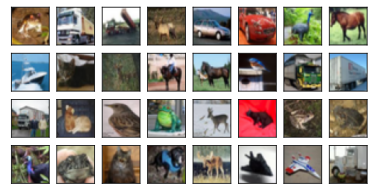

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广。
在这里，我们[**只使用最简单的随机左右翻转**]。
此外，我们使用`ToTensor`实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1。


In [12]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

接下来，我们[**定义一个辅助函数，以便于读取图像和应用图像增广**]。PyTorch数据集提供的`transform`参数应用图像增广来转化图像。有关`DataLoader`的详细介绍，请参阅 :numref:`sec_fashion_mnist`。


In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

### 多GPU训练

我们在CIFAR-10数据集上训练 :numref:`sec_resnet`中的ResNet-18模型。
回想一下 :numref:`sec_multi_gpu_concise`中对多GPU训练的介绍。
接下来，我们[**定义一个函数，使用多GPU对模型进行训练和评估**]。


In [14]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [15]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

现在，我们可以[**定义`train_with_data_aug`函数，使用图像增广来训练模型**]。该函数获取所有的GPU，并使用Adam作为训练的优化算法，将图像增广应用于训练集，最后调用刚刚定义的用于训练和评估模型的`train_ch13`函数。


In [16]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

让我们使用基于随机左右翻转的图像增广来[**训练模型**]。


loss 0.167, train acc 0.942, test acc 0.842
1202.8 examples/sec on [device(type='cuda', index=0)]


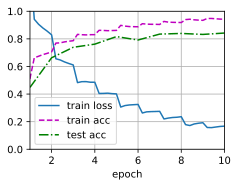

In [17]:
train_with_data_aug(train_augs, test_augs, net)

## 小结

* 图像增广基于现有的训练数据生成随机图像，来提高模型的泛化能力。
* 为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，而在预测过程中不使用带随机操作的图像增广。
* 深度学习框架提供了许多不同的图像增广方法，这些方法可以被同时应用。

## 练习

1. 在不使用图像增广的情况下训练模型：`train_with_data_aug(no_aug, no_aug)`。比较使用和不使用图像增广的训练结果和测试精度。这个对比实验能支持图像增广可以减轻过拟合的论点吗？为什么？
2. 在基于CIFAR-10数据集的模型训练中结合多种不同的图像增广方法。它能提高测试准确性吗？
3. 参阅深度学习框架的在线文档。它还提供了哪些其他的图像增广方法？


[Discussions](https://discuss.d2l.ai/t/2829)
